## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Carga datos y representa la serie

In [2]:
df = pd.read_csv('data/AirPassengers.csv', parse_dates=['date'], index_col = 'date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [3]:
df.head(20)

,value
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


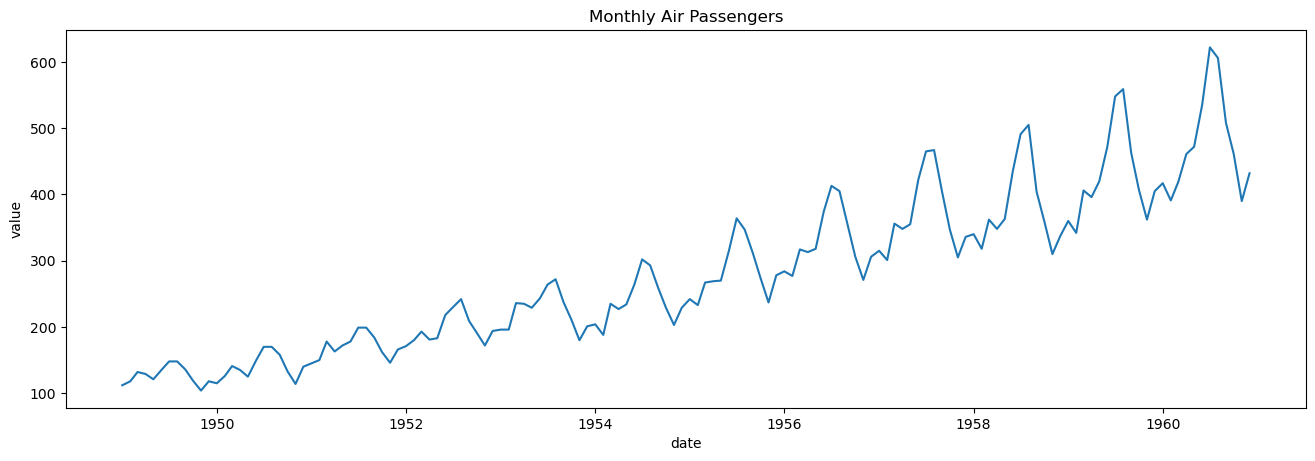

In [26]:
def plot_df(df, x, y, title="", xlabel='date', ylabel='value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly Air Passengers')

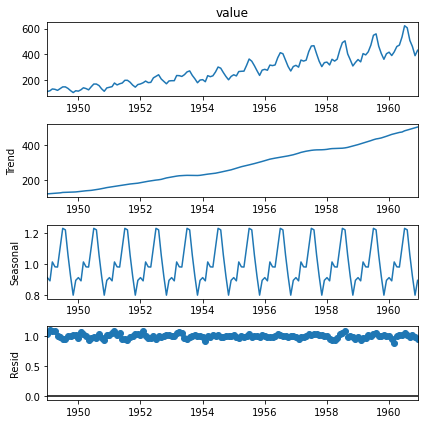

In [27]:
# Descomponemos la serie para observar la tendencia, seasonality y residuos.
# Encontramos seasonality cada año. Yearly seasonality.

from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df['value'], model='multiplicative',extrapolate_trend='freq')

# Ploteamos
plt.rcParams.update({'figure.figsize': (6,6)})
decomposed.plot();

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

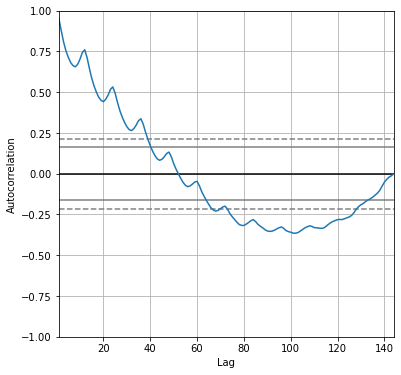

In [28]:
# Pintamos autocorrelación 

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['value'])

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior

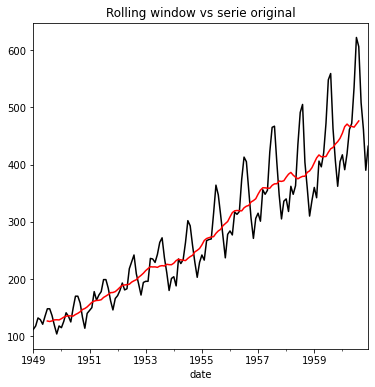

In [29]:
s = 12 #seasonality anual


#Moving Average
df_ma = df['value'].rolling(s, center=True, closed='both').mean()

df['value'].plot(color='k')
df_ma.plot(color = 'r', title='Rolling window vs serie original');

## 3. Comprueba de manera estadística si la serie es o no stationary.

El test estadístico es positivo, lo cual implica que es mucho menos probable que rechacemos la hipótesis nula (no estacionaria).

Al comparar el estadístico ADF con los valores críticos, parece que no podríamos rechazar la hipótesis nula de que la serie temporal no es estacionaria y en consecuencia afirmamos que la serie tiene una estructura que sí que es dependiente del tiempo.

Un valor p por encima del umbral sugiere que no rechazamos la hipótesis nula (no estacionario).

In [30]:
# test de Dickey-Fuller

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['value'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


## 4. Aplica una transformación logarítmica

Podemos ver que el valor es mayor que los valores críticos, lo que significa que podemos rechazar la hipótesis nula y, a su vez, que la serie de tiempo no es estacionaria.

Sin embargo nos sigue interesando aplicar la transformación porque conseguimos estabilizar la varianza.

In [31]:
df['value'] = np.log(df['value'])

result = adfuller(df['value'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.717017
p-value: 0.422367
	1%: -3.482
	5%: -2.884
	10%: -2.579


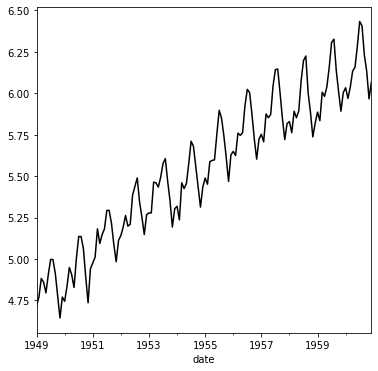

In [32]:
# Observamos que la varianza está más estabilizada
df['value'].plot(color='k');

## 5. Divide en train y test. Guarda 20 muestras para test.

In [33]:
train = df['value'][0:125]
test = df['value'][125:]

## 6. Crea tu primer modelo ARIMA

In [34]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

"""Primero pruebo sin estationary"""


model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    stationary=False,
                    warnings=False,
                    error_action = 'ignore',
                    trace=True,
                    stepwise=True)
print(model.aic())

predictions = model.predict(19)

print("MSE:", mean_squared_error(test.values, predictions))
print("RMSE:", np.sqrt(mean_squared_error(test.values, predictions)))
print("MAE:", mean_absolute_error(test.values, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-211.160, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-203.811, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-205.275, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-206.552, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-204.531, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-206.463, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-228.561, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-232.461, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-231.086, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-236.651, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-216.484, Time=0.22 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-235.7

In [35]:
'''
Ahora probamos con stationary de m=12
'''

model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m=12, # tengo que ver qué significa este parámetro
                    stationary=False,
                    warnings=False,
                    error_action = 'ignore',
                    trace=True,
                   stepwise=True)
print(model.aic())

predictions = model.predict(19)

print("MSE:", mean_squared_error(test.values, predictions))
print("RMSE:", np.sqrt(mean_squared_error(test.values, predictions)))
print("MAE:", mean_absolute_error(test.values, predictions))

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-413.935, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-294.133, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-403.899, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-357.432, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-126.477, Time=0.01 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-415.947, Time=0.49 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-388.347, Time=0.12 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-414.034, Time=1.41 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-409.560, Time=0.49 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-412.509, Time=1.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-412.579, Time=0.22 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-415.212, Time=0.38 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-414.401, Time=0.71 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-304.397, Time=0.14 sec
 ARIMA(0,0,2)(0,1,1

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  125
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 213.389
Date:                              Tue, 27 Jul 2021   AIC                           -416.779
Time:                                      17:21:36   BIC                           -403.142
Sample:                                           0   HQIC                          -411.245
                                              - 125                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0196      0.010      2.030      0.042       0.001       0.038
ar.L1          0.6074      0.086      7.096      0.000       0.440       0.775
ar.L2          0.2327      0.090      2.600      0.009       0.057       0.408
ma.S.L12      -0.5580      0.116     -4.792      0.000      -0.786      -0.330
sigma2         0.0013      0.000      7.767      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.03
Prob(Q):                              0.99   Prob(JB):                         0.08
Heteroskedasticity (H):               0.41   Skew:                             0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 7. Representa en una gráfica los datos de test y tus predicciones.

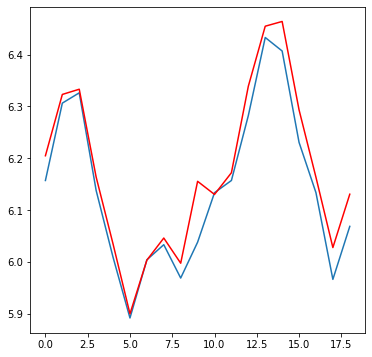

In [37]:
plt.plot(test.values)
plt.plot(predictions,color='red');

## 8. Prueba otros modelos, a ver qué performance presentan.

In [38]:
for i in range(12,0,-1):
    df['t-'+str(i)] = df['value'].shift(i) # Cambie el índice por el número deseado de períodos con una frecuencia de tiempo opcional.
df.dropna(inplace=True)

In [39]:
df.head()

,value,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1950-01-01,4.744932,4.718499,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685
1950-02-01,4.836282,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932
1950-03-01,4.948760,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282
1950-04-01,4.905275,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760
1950-05-01,4.828314,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760,4.905275


In [40]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, 1].values

X_train = X[:125-12]
X_test = X[125-12:]
y_train = Y[:125-12]
y_test = Y[125-12:]

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Shape y_train:", y_train.shape)
print("Shape y_test:", y_test.shape)

Shape X_train: (113, 12)
Shape X_test: (19, 12)
Shape y_train: (113,)
Shape y_test: (19,)


In [41]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
tree = DecisionTreeRegressor()  # max-depth not set

# Fit the model to the training features and targets
tree.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

print("MSE:", mean_squared_error(tree.predict(X_test), y_test))
print("RMSE:", np.sqrt(mean_squared_error(tree.predict(X_test), y_test)))
print("MAE:", mean_absolute_error(tree.predict(X_test), y_test))

MSE: 0.004125925695465264
RMSE: 0.06423336901848808
MAE: 0.035893034484790004


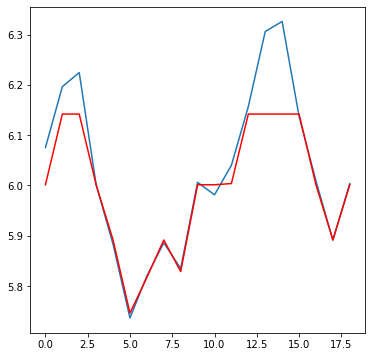

In [42]:
plt.plot(y_test);
plt.plot(tree.predict(X_test), color='red');